# SKAB v0.9

* **datetime**: Represents dates and times of the moment when the value is written to the database (YYYY-MM-DD hh:mm:ss)
* **Accelerometer1RMS**: Shows a vibration acceleration (Amount of g units);
* **Accelerometer2RMS**: Shows a vibration acceleration (Amount of g units);
* **Current**: Shows the amperage on the electric motor (Ampere);
* **Pressure**: Represents the pressure in the loop after the water pump (Bar);
* **Temperature**: Shows the temperature of the engine body (The degree Celsius);
* **Thermocouple**: Represents the temperature of the fluid in the circulation loop (The degree Celsius);
* **Voltage**: Shows the voltage on the electric motor (Volt);
* **RateRMS**: Represents the circulation flow rate of the fluid inside the loop (Liter per minute);
* **anomaly**: Shows if the point is anomalous (0 or 1).
* **changepoint**: Shows if the point is a changepoint for collective anomalies (0 or 1)

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PhD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred, scores):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, scores)#, max_fpr=0.1)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    """
    Encontra o threshold ótimo com base na curva ROC,
    considerando apenas FPR <= max_fpr se especificado.
    Retorna fpr, tpr, thresholds, best_threshold e roc_auc.
    """
    # Calcula curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Filtra os pontos se max_fpr for especificado
    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr = fpr[mask]
        tpr = tpr[mask]
        thresholds = thresholds[mask]

    # AUC usando função apropriada
    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)

    # Índice do ponto ótimo
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]

    return fpr, tpr, thresholds, best_threshold, roc_auc



def plot_roc_curve(fpr, tpr, thresholds, best_threshold, roc_auc, max_fpr=None):
    """
    Plota a curva ROC a partir de fpr, tpr e thresholds já calculados.
    Destaca o melhor threshold.
    """
    optimal_idx = np.where(thresholds == best_threshold)[0][0]

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.3f})', lw=2)
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', zorder=5,
                label=f'Melhor Threshold = {best_threshold:.3f}')

    # Linhas auxiliares para melhor visualização
    plt.axhline(y=tpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)
    plt.axvline(x=fpr[optimal_idx], color='gray', linestyle='--', alpha=0.6)

    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curva ROC{" (FPR ≤ " + str(max_fpr) + ")" if max_fpr else ""}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [5]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [6]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.iloc[:, 0]
    test_scores_std = df.iloc[:, 1]
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

In [7]:
train = pd.read_parquet('./data/skab_train_agg_dwt.parquet.gzip') 
test = pd.read_parquet('./data/skab_test_agg_dwt.parquet.gzip') 

In [8]:
train = train.rename(columns={'anomaly': 'target', 'datetime': 'timestamp'})
test = test.rename(columns={'anomaly': 'target', 'datetime': 'timestamp'})

In [9]:
train.head()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
0,32.115408,0.324407,32.000,32.9962,0.999943,0.279597,2020-03-09 10:14:00,value1,0.0
1,32.293166,0.493304,31.004,32.9962,0.999856,0.455720,2020-03-09 10:15:00,value1,0.0
2,32.105353,0.308289,32.000,32.9964,0.999943,0.255478,2020-03-09 10:16:00,value1,0.0
3,32.070182,0.256715,32.000,32.9964,0.999963,0.233720,2020-03-09 10:17:00,value1,0.0
4,32.157911,0.366335,32.000,32.9966,0.999929,0.339662,2020-03-09 10:18:00,value1,0.0


In [10]:
test.head()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
256,29.859143,1.468449,28.0263,32.9745,0.999925,1.977376,2020-03-09 14:31:00,value1,1.0
257,32.051431,0.423857,31.0265,32.9743,0.999911,0.431980,2020-03-09 14:32:00,value1,0.0
258,32.232359,0.490260,31.0265,33.0000,0.999890,0.469790,2020-03-09 14:33:00,value1,0.0
259,32.140928,0.339742,32.0000,32.9740,0.999939,0.317402,2020-03-09 14:34:00,value1,0.0
260,32.263825,0.429386,32.0000,33.0000,0.999905,0.395182,2020-03-09 14:35:00,value1,0.0


In [11]:
test.tail()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
394,28.646413,0.456185,28.0000,29.0000,0.999825,0.343275,2020-03-09 17:10:00,value2,1.0
395,28.510765,0.476619,28.0000,29.0000,0.999842,0.471291,2020-03-09 17:11:00,value2,1.0
396,29.862382,1.521862,28.0000,32.0000,0.999865,2.041854,2020-03-09 17:12:00,value2,1.0
397,32.103325,0.496102,31.0451,32.9562,0.999865,0.447332,2020-03-09 17:13:00,value2,1.0
398,32.222511,0.416399,32.0000,32.9562,0.999923,0.330445,2020-03-09 17:14:00,value2,0.0


In [12]:
test.shape

(80, 9)

In [13]:
train.target.value_counts()

target
0.0    193
1.0    126
Name: count, dtype: int64

In [14]:
feature_model= [col for col in train.columns if col not in ['changepoint', 'timestamp', 'valve', 'target']]
feature_model

['Volume Flow RateRMS_mean',
 'Volume Flow RateRMS_std',
 'Volume Flow RateRMS_min',
 'Volume Flow RateRMS_max',
 'Volume Flow RateRMS_energy_L0',
 'Volume Flow RateRMS_std_L0']

In [15]:
development = train.reset_index(drop=True)

development.shape

(319, 9)

In [16]:
validation = test.reset_index(drop=True)
validation.shape

(80, 9)

In [17]:
validation.head()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
0,29.859143,1.468449,28.0263,32.9745,0.999925,1.977376,2020-03-09 14:31:00,value1,1.0
1,32.051431,0.423857,31.0265,32.9743,0.999911,0.431980,2020-03-09 14:32:00,value1,0.0
2,32.232359,0.490260,31.0265,33.0000,0.999890,0.469790,2020-03-09 14:33:00,value1,0.0
3,32.140928,0.339742,32.0000,32.9740,0.999939,0.317402,2020-03-09 14:34:00,value1,0.0
4,32.263825,0.429386,32.0000,33.0000,0.999905,0.395182,2020-03-09 14:35:00,value1,0.0


In [18]:
# validation_well = validation[(validation['well']=='WELL-00006')].reset_index(drop=True)

# validation_well.shape

In [19]:
train_no_anomalies = development[development.target==0]
train_no_anomalies.shape

(193, 9)

In [20]:
development.head()

,Volume Flow RateRMS_mean,Volume Flow RateRMS_std,Volume Flow RateRMS_min,Volume Flow RateRMS_max,Volume Flow RateRMS_energy_L0,Volume Flow RateRMS_std_L0,timestamp,valve,target
0,32.115408,0.324407,32.000,32.9962,0.999943,0.279597,2020-03-09 10:14:00,value1,0.0
1,32.293166,0.493304,31.004,32.9962,0.999856,0.455720,2020-03-09 10:15:00,value1,0.0
2,32.105353,0.308289,32.000,32.9964,0.999943,0.255478,2020-03-09 10:16:00,value1,0.0
3,32.070182,0.256715,32.000,32.9964,0.999963,0.233720,2020-03-09 10:17:00,value1,0.0
4,32.157911,0.366335,32.000,32.9966,0.999929,0.339662,2020-03-09 10:18:00,value1,0.0


In [21]:
X_dev = development[feature_model].values
y_dev = development['target'].values

In [22]:
y_dev.sum()

126.0

In [23]:
len(y_dev)

319

In [24]:
X_no_anomalies = train_no_anomalies[feature_model].values

In [25]:
import numpy as np
import gym
from gym import spaces
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import time

class AnomalyDetectionEnv(gym.Env):
    def __init__(self, X, y, tscv, features, model_factory, param_ranges):
        """
        Ambiente de RL para otimização de modelos de detecção de anomalias.

        :param X: Dados de entrada (numpy array)
        :param y: Rótulos (numpy array)
        :param tscv: TimeSeriesSplit para validação cruzada
        :param features: Lista de features usadas
        :param model_factory: Função que recebe um conjunto de hiperparâmetros e retorna um modelo
        :param param_ranges: Dicionário com limites inferior e superior para cada hiperparâmetro
        """
        super(AnomalyDetectionEnv, self).__init__()

        self.X = X
        self.y = y
        self.tscv = tscv
        self.features = features
        self.model_factory = model_factory
        self.param_ranges = param_ranges

        # Espaço de ação baseado nos hiperparâmetros
        low_bounds = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)
        high_bounds = np.array([param_ranges[p][1] for p in param_ranges], dtype=np.float32)
        self.action_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Espaço de observação (hiperparâmetros atuais)
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Estado inicial: média dos limites dos hiperparâmetros
        # self.state = np.array([(param_ranges[p][0] + param_ranges[p][1]) / 2 for p in param_ranges], dtype=np.float32)
        self.state = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)

        # Histórico de métricas
        # self.metrics_history = {
        #     'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': []
        # }
        self.metrics_history = {
            'roc_auc': []
        }

        self.rewards_history = []  # Histórico de recompensas
        self.q_values_history = []  # Histórico de Q-values
        # self.entropy_history = []  # Histórico de entropia
        # self.critic_loss_history = []  # Histórico de critic loss

        # Lista para armazenar os resultados detalhados de cada rodada
        self.results = []

    # def find_optimal_threshold(self, y_true, y_scores, metric='f1'):
    #     precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    #     try:
    #         f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    #     except:
    #           f1_scores = 0    
    #     best_idx = np.argmax(f1_scores)
    #     return thresholds[best_idx], f1_scores[best_idx]

    def step(self, action):
        # Verificar se a ação contém valores inválidos
        if np.isnan(action).any():
            print("Ação inválida detectada:", action)
            return self.reset(), 0, True, {"invalid_action": True}

        # Criar dicionário de hiperparâmetros ajustados dentro dos limites
        params = {key: np.clip(action[i], *self.param_ranges[key]) for i, key in enumerate(self.param_ranges)}

        # Criar o modelo com os hiperparâmetros escolhidos
        model = self.model_factory(**params)

        # Pipeline de pré-processamento e modelo
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Validação cruzada e avaliação do modelo
        # split_scores = {
        #     'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': [], 'fit_time': [], 'score_time': []
        # }
        split_scores = {
            'roc_auc': [], 'fit_time': [], 'score_time': []
        }

        for train_index, test_index in self.tscv.split(self.X):
            X_train_split = self.X[train_index][self.y[train_index] == 0]

            X_test_split = self.X[test_index]
            y_test_split = self.y[test_index]

            start_fit = time.time()
            pipeline.fit(X_train_split)
            fit_time = time.time() - start_fit

            start_score = time.time()
            y_scores = -pipeline.decision_function(X_test_split) if hasattr(pipeline, "decision_function") else pipeline.predict_proba(X_test_split)[:, 1]
            # y_pred = pipeline.predict(X_test_split)
            score_time = time.time() - start_score

            # Mapear previsões para anomalias (0 = normal, 1 = anomalia)
            # y_pred = np.where(y_pred == -1, 1, 0)
            # best_threshold, best_f1 = self.find_optimal_threshold(y_test_split, y_scores)
            # y_pred = (y_scores >= best_threshold).astype(int)

            # Calcular métricas
            # precision = precision_score(y_test_split, y_pred, average='binary', zero_division=0)
            # recall = recall_score(y_test_split, y_pred, average='binary', zero_division=0)
            # f1 = f1_score(y_test_split, y_pred, average='binary', zero_division=0)
            roc_auc = roc_auc_score(y_test_split, y_scores)#, max_fpr=0.1) 
            # pr_auc = average_precision_score(y_test_split, y_scores)      

            # Calcular especificidade
            # tn, fp, fn, tp = confusion_matrix(y_test_split, y_pred).ravel()
            # specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            # split_scores['f1_score'].append(f1)
            # split_scores['precision'].append(precision)
            # split_scores['recall'].append(recall)
            split_scores['roc_auc'].append(roc_auc)
            # split_scores['pr_auc'].append(pr_auc)
            # split_scores['specificity'].append(specificity)
            split_scores['fit_time'].append(fit_time)
            split_scores['score_time'].append(score_time)

        # Adicionar resultados detalhados
        self.results.append({
            "params": params,
            "fold_scores": split_scores,
            # "mean_test_f1_score": np.mean(split_scores['f1_score']),
            # "std_test_f1_score": np.std(split_scores['f1_score']),
            # "mean_test_specificity": np.mean(split_scores['specificity']),
            # "std_test_specificity": np.std(split_scores['specificity']),
            # "mean_test_precision": np.mean(split_scores['precision']),
            # "std_test_precision": np.std(split_scores['precision']),
            # "mean_test_recall": np.mean(split_scores['recall']),
            # "std_test_recall": np.std(split_scores['recall']),
            "mean_test_roc_auc": np.mean(split_scores['roc_auc']),
            "std_test_roc_auc": np.std(split_scores['roc_auc']),
            # "mean_test_pr_auc": np.mean(split_scores['pr_auc']),
            # "std_test_pr_auc": np.std(split_scores['pr_auc']),
            "mean_fit_time": np.mean(split_scores['fit_time']),
            "std_fit_time": np.std(split_scores['fit_time']),
            "mean_score_time": np.mean(split_scores['score_time']),
            "std_score_time": np.std(split_scores['score_time']),
        })

        # Recompensa baseada no AUC-ROC médio
        reward = 100*(np.mean(split_scores['roc_auc']) - np.std(split_scores['roc_auc']))
        # reward = 100*(np.mean(split_scores['f1_score']) - np.std(split_scores['f1_score']))

        # reward = 100*(np.mean(split_scores['pr_auc']) - np.std(split_scores['pr_auc']))

        # reward = 2 * np.mean(split_scores['roc_auc']) - 1  # Gini

        # reward = np.mean(split_scores['f1_score'])
        # reward = np.mean(split_scores['pr_auc'])

        self.rewards_history.append(reward)

        # Atualizar histórico de métricas
        for metric in self.metrics_history:
            self.metrics_history[metric].append(np.mean(split_scores[metric]))

        # Atualizar estado
        self.state = np.array(list(params.values()), dtype=np.float32)

        return self.state, reward, True, {}

    def reset(self):
        self.state = np.array([(self.param_ranges[p][0] + self.param_ranges[p][1]) / 2 for p in self.param_ranges], dtype=np.float32)
        return self.state

    def render(self, mode='human'):
        pass

    def get_results_table(self):
        """ Retorna um DataFrame com os resultados da validação cruzada. """
        return pd.DataFrame(self.results)
    

### Isolation Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [26]:
from sklearn.ensemble import IsolationForest

def isolation_forest_factory(**params):
    return IsolationForest(
        n_estimators=int(params['n_estimators']),
        contamination=params['contamination'],
        max_samples=params['max_samples'],
        max_features=int(params['max_features']),
        # bootstrap=bool(params['bootstrap']),
        random_state=42
    )

param_ranges_if = {
    'n_estimators': (5, 256),
    'contamination': (0.0001, 0.005),
    'max_samples': (0.3, 1.0),
    'max_features': (0.3, 1.0)
    # 'bootstrap': (0, 1)  # 0 = False, 1 = True
}

In [27]:
# === Visualização das Métricas ===
def plot_metrics(metrics_history):
    plt.figure(figsize=(12, 8))
    for metric, values in metrics_history.items():
        plt.plot(values, label=metric)
    plt.xlabel('Episódios')
    plt.ylabel('Valor da Métrica')
    plt.title('Evolução das Métricas Durante o Treinamento')
    plt.legend()
    plt.grid()
    plt.show()

In [28]:
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
import torch

class SACMetricsCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(SACMetricsCallback, self).__init__(verbose)
        self.rewards_history = []
        self.q_values_mean_history = []
        self.q_values_std_history = []
        self.q_values_q1_history = []
        self.q_values_q2_history = []

    def _on_step(self) -> bool:
        # Armazenar recompensas
        if "rewards" in self.locals:
            self.rewards_history.append(self.locals["rewards"][0])

        # Obter o estado atual do ambiente
        if self.training_env is not None:
            obs = self.training_env.get_attr('state')[0]

            if isinstance(obs, np.ndarray):
                obs_tensor = torch.tensor(obs, dtype=torch.float32, device=self.model.device).unsqueeze(0)
                with torch.no_grad():
                    actions = self.model.policy.actor(obs_tensor)
                    if isinstance(actions, tuple):
                        actions = actions[0]

                    # Chamando o critic corretamente (retorna q1 e q2)
                    q1, q2 = self.model.policy.critic(obs_tensor, actions)

                    # Salvar valores separadamente
                    q1_value = q1.mean().item()
                    q2_value = q2.mean().item()
                    self.q_values_q1_history.append(q1_value)
                    self.q_values_q2_history.append(q2_value)

                    # Salvar média e desvio padrão
                    q_values = torch.cat([q1, q2], dim=1)
                    self.q_values_mean_history.append(q_values.mean().item())
                    self.q_values_std_history.append(q_values.std().item())

        return True


In [29]:
import time
# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv(X_dev, y_dev, tscv, feature_model, isolation_forest_factory, param_ranges_if)

# Modelo SAC
model_iforest_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)


start_time = time.time()  # Inicia o cronômetro

# Treinamento do agente
callback = SACMetricsCallback()
model_iforest_sac.learn(total_timesteps=1000, callback=callback)

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 87.9     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 87.4     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 87       |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [30]:
results_df_iforest = env.get_results_table()
results_df_iforest.head()

,params,fold_scores,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'n_estimators': 85.15389251708984, 'contamina...","{'roc_auc': [0.8503989361702128, 0.92686170212...",0.902232,0.036667,0.183099,0.042079,0.004369,0.001949
1,"{'n_estimators': 91.67301940917969, 'contamina...","{'roc_auc': [0.8896276595744681, 0.92420212765...",0.918678,0.021817,0.147485,0.006936,0.003961,0.001363
2,"{'n_estimators': 222.17027282714844, 'contamin...","{'roc_auc': [0.8523936170212767, 0.92885638297...",0.907594,0.039374,0.392275,0.055005,0.006574,0.001162
3,"{'n_estimators': 87.39315795898438, 'contamina...","{'roc_auc': [0.8769946808510638, 0.93550531914...",0.911962,0.025216,0.137966,0.003235,0.003486,0.000391
4,"{'n_estimators': 227.3557586669922, 'contamina...","{'roc_auc': [0.8623670212765958, 0.93018617021...",0.905985,0.030905,0.391845,0.045940,0.008078,0.002271


In [49]:
results_df_iforest.to_csv('./metrics_skab/results_df_iforest_dwt.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

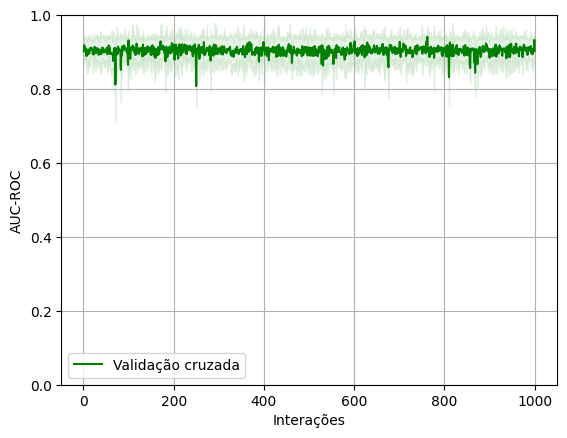

In [50]:
results_df_iforest2 = pd.read_csv('./metrics_skab/results_df_iforest_dwt.csv')

results_df_iforest2  = results_df_iforest2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_iforest2, title="iforest", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [33]:
# IsolationForest(contamination=0.0002, max_features=0.94, max_samples=0.37,
#                 n_estimators=76, random_state=42)

In [32]:
results_df_iforest['roc_auc_adjusted'] = results_df_iforest['mean_test_roc_auc'] - results_df_iforest['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_iforest['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = results_df_iforest.loc[999]
best_params = results_df_iforest.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 


Melhores parâmetros encontrados (máxima média ajustada): {'n_estimators': 13.46967887878418, 'contamination': 0.00014096719678491354, 'max_samples': 0.6066786050796509, 'max_features': 0.3095110058784485}

Métricas: params               {'n_estimators': 13.46967887878418, 'contamina...
fold_scores          {'roc_auc': [0.920877659574468, 0.952792553191...
mean_test_roc_auc                                               0.9328
std_test_roc_auc                                              0.014224
mean_fit_time                                                 0.027061
std_fit_time                                                  0.004526
mean_score_time                                               0.000868
std_score_time                                                0.000182
roc_auc_adjusted                                              0.918577
Name: 998, dtype: object


In [35]:
# best_params_idx 

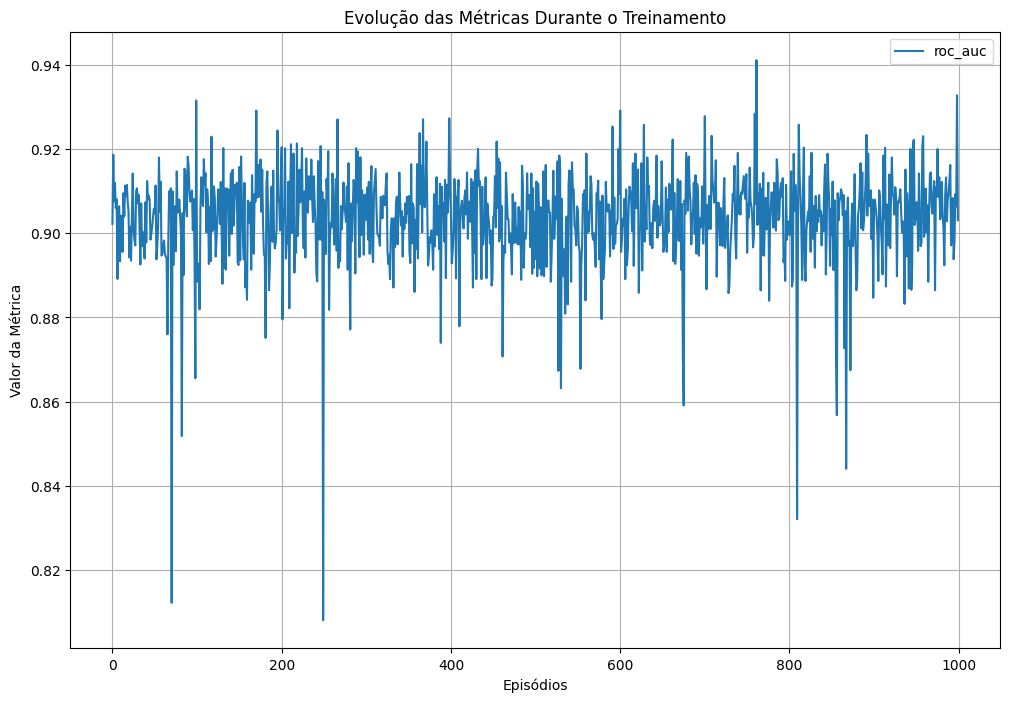

In [33]:

plot_metrics(env.metrics_history)


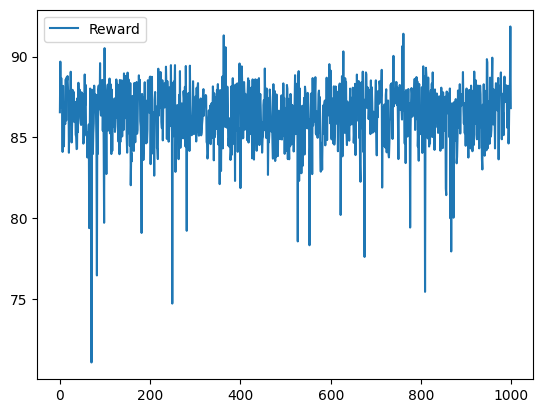

In [34]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

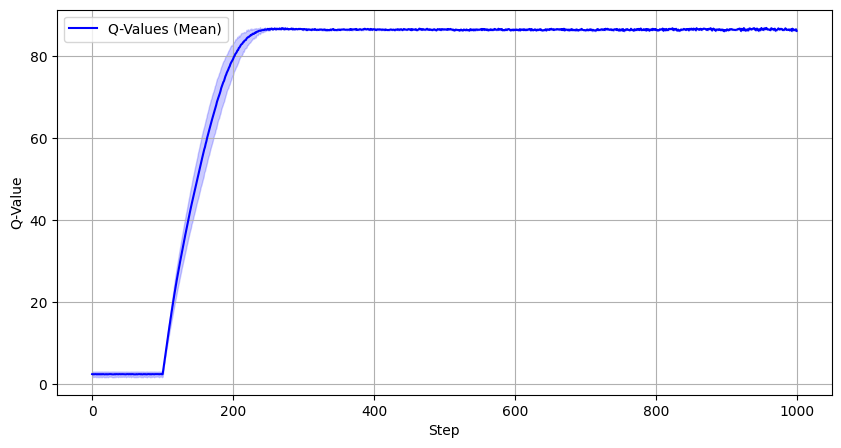

In [35]:
# plt.plot(callback.q_values_history, label="Q-Values")
# plt.legend()
# plt.show()

q_mean = np.array(callback.q_values_mean_history)
q_std = np.array(callback.q_values_std_history)

plt.figure(figsize=(10, 5))
plt.plot(q_mean, label="Q-Values (Mean)", color="blue")
plt.fill_between(range(len(q_mean)),
                 q_mean - q_std,
                 q_mean + q_std,
                 alpha=0.2, color="blue")
plt.xlabel("Step")
plt.ylabel("Q-Value")
# plt.title("Evolução dos Q-Values (Média ± Desvio Padrão)")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_skab/rewards_history_iforest_dwt.csv', index=False)
pd.DataFrame(callback.q_values_mean_history).to_csv('./metrics_skab/q_values_mean_history_iforest_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q1_history).to_csv('./metrics_skab/q_values_q1_history_iforest_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q2_history).to_csv('./metrics_skab/q_values_q2_history_iforest_dwt.csv', index=False)
pd.DataFrame(callback.q_values_std_history).to_csv('./metrics_skab/q_values_std_history_iforest_dwt.csv', index=False)

In [36]:
best_params['params']

{'n_estimators': 13.46967887878418,
 'contamination': 0.00014096719678491354,
 'max_samples': 0.6066786050796509,
 'max_features': 0.3095110058784485}

In [37]:
n_estimators_best = int(best_params['params'].get('n_estimators'))
contamination_best = round(float(best_params['params'].get('contamination')), 5)
max_samples_best = round(float(best_params['params'].get('max_samples')), 2)
max_features_best = round(float(best_params['params'].get('max_features')), 2)
bootstrap_best = bool(best_params['params'].get('bootstrap'))

print(f"Melhores hiperparâmetros encontrados: n_estimators={n_estimators_best}, contamination={contamination_best}, "
      f"max_samples={max_samples_best}, max_features={max_features_best}, bootstrap={bootstrap_best}")

Melhores hiperparâmetros encontrados: n_estimators=13, contamination=0.00014, max_samples=0.61, max_features=0.31, bootstrap=False


In [38]:
estimator  = IsolationForest(
    n_estimators=n_estimators_best,
    contamination=contamination_best,
    max_samples=max_samples_best,
    max_features=max_features_best,
    bootstrap=bootstrap_best,
    random_state=42
)


best_model_iforest = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

best_model_iforest.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 IsolationForest(contamination=0.00014, max_features=0.31,
                                 max_samples=0.61, n_estimators=13,
                                 random_state=42))])

In [39]:
std = StandardScaler()
std.fit(X_no_anomalies)

StandardScaler()

In [40]:
scores_dev = -best_model_iforest.decision_function(X_dev)
final_auc = roc_auc_score(y_dev, scores_dev, max_fpr=1)
print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.9250


Melhor Threshold: -0.0936


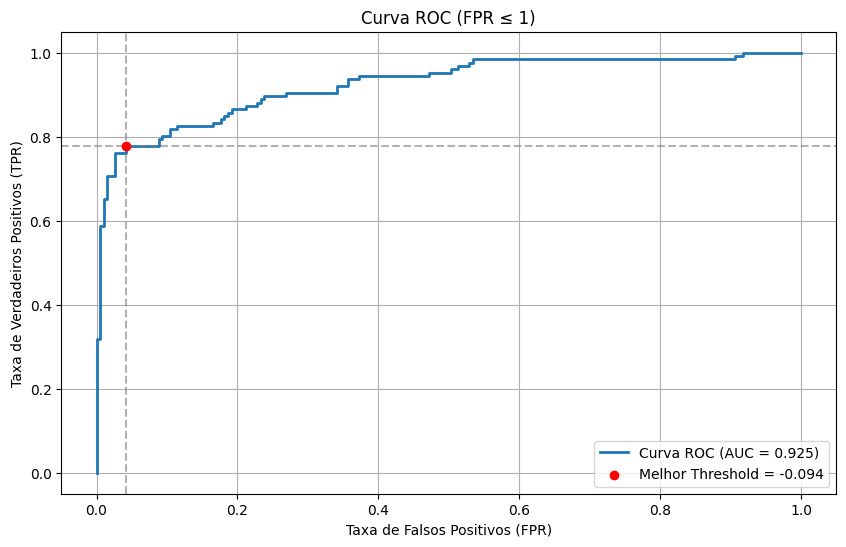

In [41]:
# Primeiro, calcula os valores da ROC e o melhor threshold
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(
    y_dev, scores_dev, max_fpr=1
)

print(f"Melhor Threshold: {best_threshold:.4f}")

# Depois, plota a curva ROC usando os valores calculados
plot_roc_curve(fpr, tpr, thresholds, best_threshold, roc_auc, max_fpr=1)

In [42]:
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

# y_pred = best_model_iforest.predict(X_dev)
# y_pred = np.where(y_pred == -1, 1, 0)  

Melhor Threshold (FPR ≤ 1): -0.0936, AUC: 0.9250
Melhore threshold:  -0.09364224492996542


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.86854   0.95855   0.91133       193
         1.0    0.92453   0.77778   0.84483       126

    accuracy                        0.88715       319
   macro avg    0.89654   0.86816   0.87808       319
weighted avg    0.89066   0.88715   0.88506       319

Specificity: 0.9585492227979274
Gini:  0.8499876634591659
ROC AUC::  0.9249938317295829


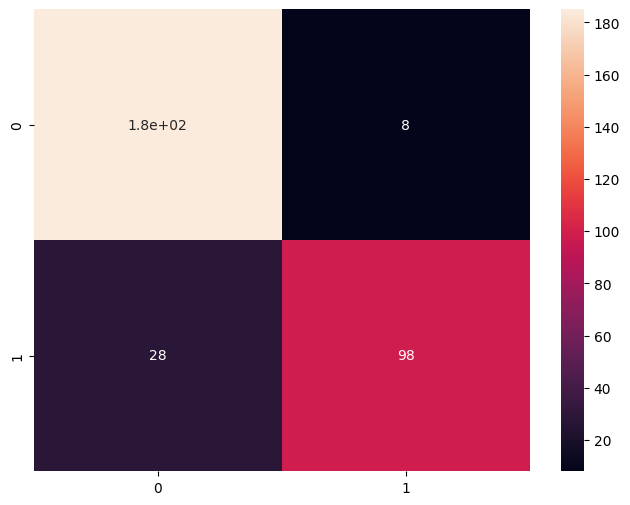

In [43]:
metrics(y_dev, y_pred, scores_dev)

In [44]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [45]:
best_model_iforest

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 IsolationForest(contamination=0.00014, max_features=0.31,
                                 max_samples=0.61, n_estimators=13,
                                 random_state=42))])

In [46]:
scores_valid = -best_model_iforest.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_pred = best_model_iforest.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)  

In [47]:
# scores_valid = -best_model_iforest.decision_function(X_valid)
final_auc = roc_auc_score(y_valid, scores_valid, max_fpr=1)
print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.8865


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.84906   0.95745   0.90000        47
         1.0    0.92593   0.75758   0.83333        33

    accuracy                        0.87500        80
   macro avg    0.88749   0.85751   0.86667        80
weighted avg    0.88077   0.87500   0.87250        80

Specificity: 0.9574468085106383
Gini:  0.773049645390071
ROC AUC::  0.8865248226950355


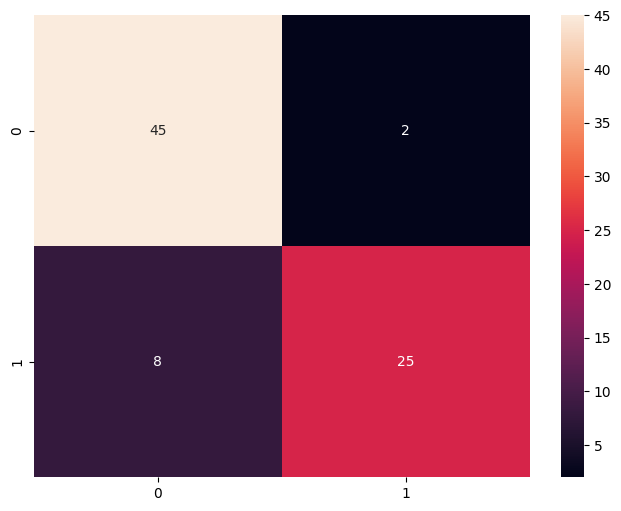

In [48]:
metrics(y_valid, y_pred, scores_valid)

In [52]:
validation['scores_forest']=-best_model_iforest.decision_function(X_valid)

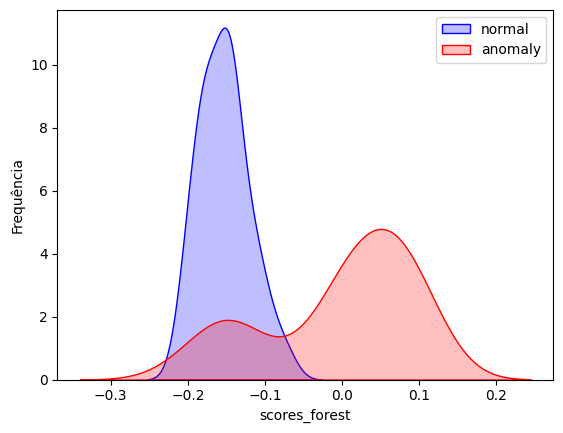

In [53]:
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 0) & (validation["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 1) & (validation["scores_forest"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [79]:
with open('./models_skab/pipeline_iForest_RL_dwt.pkl', 'wb') as file: 
    pickle.dump(best_model_iforest, file)

## Local Outlier Factor

In [29]:
from sklearn.neighbors import LocalOutlierFactor

In [30]:
def lof_factory(**params):
    return LocalOutlierFactor(
        n_neighbors=int(params['n_neighbors']),
        contamination=params['contamination'],
        novelty=True,
        n_jobs=-1
    )

param_ranges_lof = {
    'n_neighbors': (3, 25),
    'contamination': (0.0001, 0.005)
}

In [31]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env_lof = AnomalyDetectionEnv(X_dev, y_dev, tscv, feature_model, lof_factory, param_ranges_lof)

# Modelo SAC
model_lof_sac = SAC(
    "MlpPolicy",
    env_lof,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

start_time = time.time()  # Inicia o cronômetro
# Treinamento do agente
callback = SACMetricsCallback()
model_lof_sac.learn(total_timesteps=1000, callback=callback)
total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 87.2     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 6        |
|    time_elapsed    | 0        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 88.9     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 7        |
|    time_elapsed    | 1        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 89.5     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [32]:

results_df_lof = env_lof.get_results_table()
results_df_lof.head()

,params,fold_scores,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'n_neighbors': 6.720311164855957, 'contaminat...","{'roc_auc': [0.7599734042553191, 0.93617021276...",0.832854,0.075082,0.026377,0.005323,0.019882,0.001550
1,"{'n_neighbors': 13.761991500854492, 'contamina...","{'roc_auc': [0.9082446808510638, 0.92553191489...",0.925775,0.014414,0.033797,0.015190,0.024796,0.002382
2,"{'n_neighbors': 22.792007446289062, 'contamina...","{'roc_auc': [0.9099069148936171, 0.91954787234...",0.924782,0.014755,0.020463,0.001449,0.018844,0.000590
3,"{'n_neighbors': 20.76763916015625, 'contaminat...","{'roc_auc': [0.9075797872340425, 0.91622340425...",0.920882,0.013182,0.018647,0.000658,0.018216,0.001309
4,"{'n_neighbors': 18.583751678466797, 'contamina...","{'roc_auc': [0.9072473404255318, 0.92021276595...",0.922325,0.013258,0.019211,0.001269,0.018748,0.000469


In [33]:
results_df_lof.to_csv('./metrics_skab/results_df_lof_dwt.csv', index=False)

In [34]:

results_df_lof['roc_auc_adjusted'] = results_df_lof['mean_test_roc_auc'] - results_df_lof['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_lof['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_lof.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 



Melhores parâmetros encontrados (máxima média ajustada): {'n_neighbors': 24.3969783782959, 'contamination': 0.0002025452849920839}

Métricas: params               {'n_neighbors': 24.3969783782959, 'contaminati...
fold_scores          {'roc_auc': [0.9115691489361701, 0.92353723404...
mean_test_roc_auc                                             0.927338
std_test_roc_auc                                              0.014676
mean_fit_time                                                 0.021073
std_fit_time                                                  0.000459
mean_score_time                                               0.020282
std_score_time                                                0.000938
roc_auc_adjusted                                              0.912663
Name: 43, dtype: object


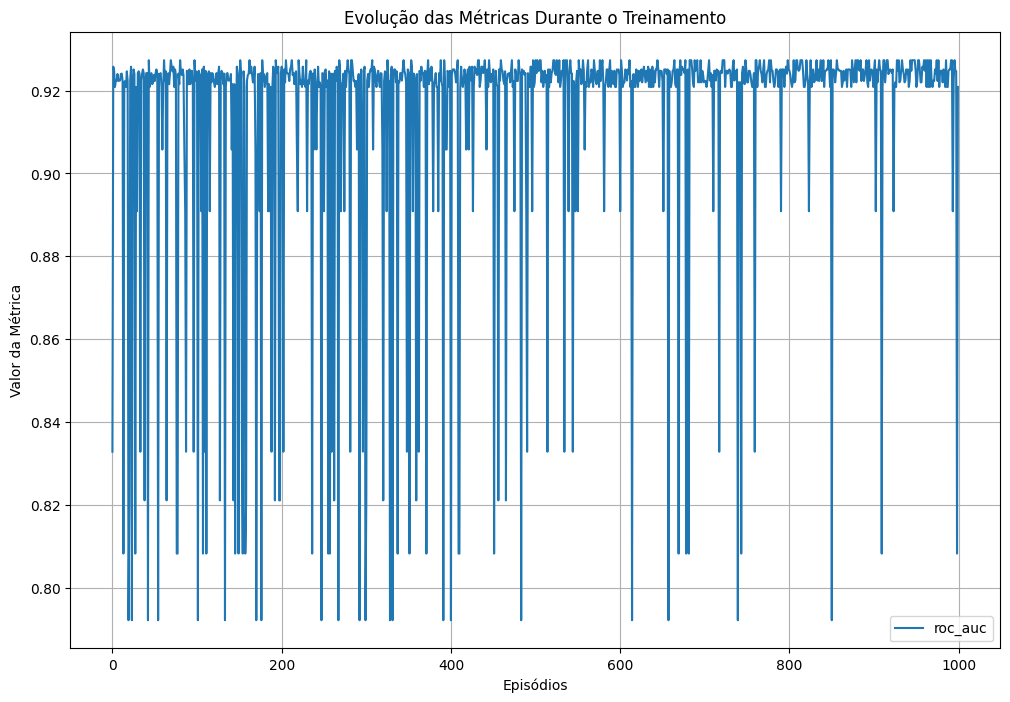

In [35]:
plot_metrics(env_lof.metrics_history)

In [36]:
# def plot_metrics_reward(metrics_history):
#     plt.figure(figsize=(12, 8))
#     plt.plot(metrics_history, label="Reward")
#     plt.xlabel('Episódios')
#     plt.ylabel('Valor da Métrica')
#     plt.title('Evolução das Métricas Durante o Treinamento')
#     plt.legend()
#     plt.grid()
#     plt.ylim(0, 1)
#     plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

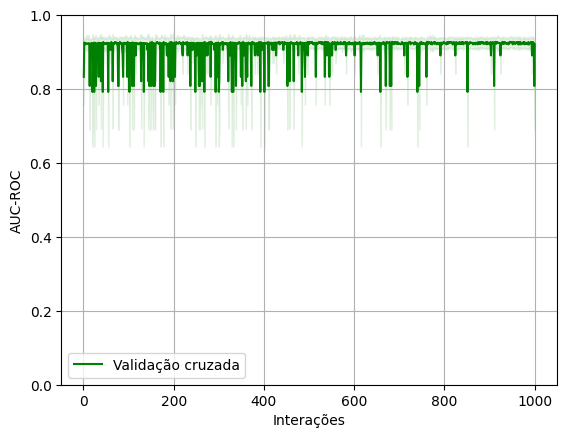

In [37]:
results_df_lof2 = pd.read_csv('./metrics_skab/results_df_lof_dwt.csv')

results_df_lof2  = results_df_lof2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_lof2, title="LOF", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [38]:
# plot_metrics_reward(callback.rewards_history)

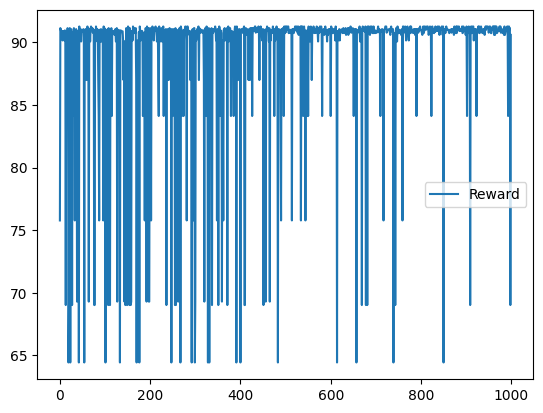

In [39]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

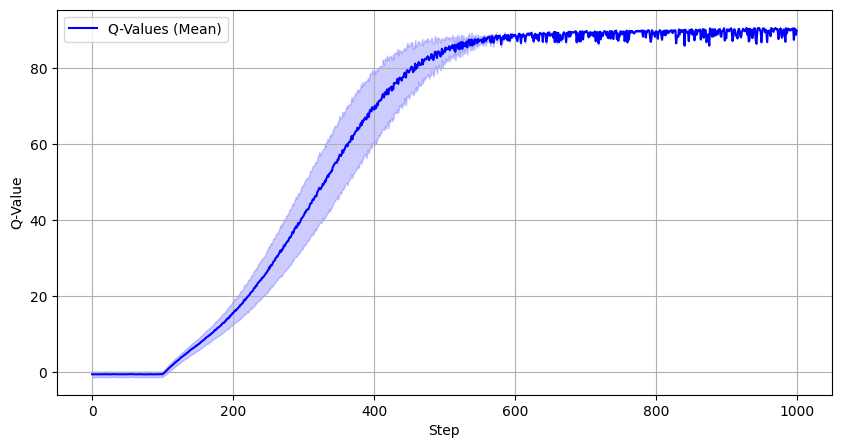

In [40]:
# plt.plot(callback.q_values_history, label="Q-Values")
# plt.legend()
# plt.show()


q_mean = np.array(callback.q_values_mean_history)
q_std = np.array(callback.q_values_std_history)

plt.figure(figsize=(10, 5))
plt.plot(q_mean, label="Q-Values (Mean)", color="blue")
plt.fill_between(range(len(q_mean)),
                 q_mean - q_std,
                 q_mean + q_std,
                 alpha=0.2, color="blue")
plt.xlabel("Step")
plt.ylabel("Q-Value")
# plt.title("Evolução dos Q-Values (Média ± Desvio Padrão)")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_skab/rewards_history_lof_dwt.csv', index=False)
pd.DataFrame(callback.q_values_mean_history).to_csv('./metrics_skab/q_values_mean_history_lof_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q1_history).to_csv('./metrics_skab/q_values_q1_history_lof_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q2_history).to_csv('./metrics_skab/q_values_q2_history_lof_dwt.csv', index=False)
pd.DataFrame(callback.q_values_std_history).to_csv('./metrics_skab/q_values_std_history_lof_dwt.csv', index=False)

In [42]:
best_params['params']

{'n_neighbors': 24.3969783782959, 'contamination': 0.0002025452849920839}

In [43]:
n_neighbors_best = int(round(best_params['params'].get('n_neighbors'), 0))
contamination_best = round(float(best_params['params'].get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_neighbors={n_neighbors_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_neighbors=24, contamination=0.0002


In [44]:
estimator_lof  = LocalOutlierFactor(
    n_neighbors=n_neighbors_best,
    contamination=contamination_best,
    novelty=True,
    n_jobs=-1
)

In [45]:
best_model_lof = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator_lof)
        ])

In [46]:
best_model_lof.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LocalOutlierFactor(contamination=0.0002, n_jobs=-1,
                                    n_neighbors=24, novelty=True))])

In [47]:
scores_dev = -best_model_lof.decision_function(X_dev)


fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)
print(f"Melhor Threshold (FPR ≤ 0.1): {best_threshold:.4f}, AUC: {roc_auc:.4f}")

# y_pred = best_model_lof.predict(X_dev)
# y_pred = np.where(y_pred == -1, 1, 0)  

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold (FPR ≤ 0.1): -2.5191, AUC: 0.9167
Melhore threshold:  -2.5191254996998866


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.89806   0.95855   0.92732       193
         1.0    0.92920   0.83333   0.87866       126

    accuracy                        0.90909       319
   macro avg    0.91363   0.89594   0.90299       319
weighted avg    0.91036   0.90909   0.90810       319

Specificity: 0.9585492227979274
Gini:  0.8333744551361133
ROC AUC::  0.9166872275680567


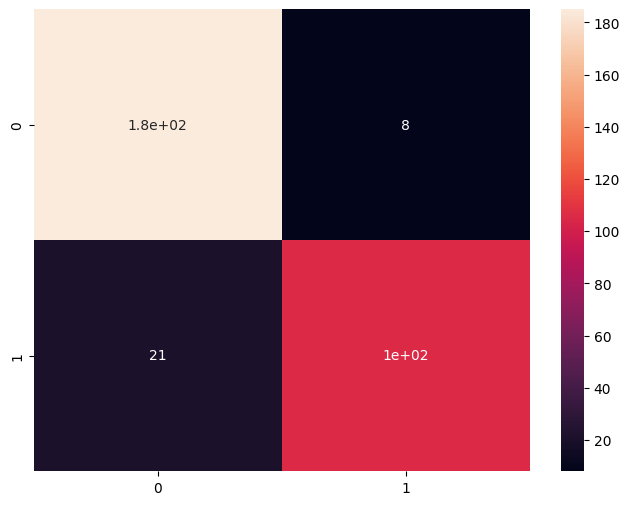

In [48]:
metrics(y_dev, y_pred, scores_dev)

In [49]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [50]:
# y_pred = best_model_lof.predict(X_valid)
# y_pred = np.where(y_pred == -1, 1, 0)  

scores_valid = -best_model_lof.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

In [51]:

# scores_valid = -best_model_lof.decision_function(X_valid)
# final_auc = roc_auc_score(y_valid, scores_valid)
# # Calcular a curva ROC  
# fpr, tpr, thresholds = roc_curve(y_valid, scores_valid)  

# print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.88889   0.85106   0.86957        47
         1.0    0.80000   0.84848   0.82353        33

    accuracy                        0.85000        80
   macro avg    0.84444   0.84977   0.84655        80
weighted avg    0.85222   0.85000   0.85058        80

Specificity: 0.851063829787234
Gini:  0.7743391360412637
ROC AUC::  0.8871695680206318


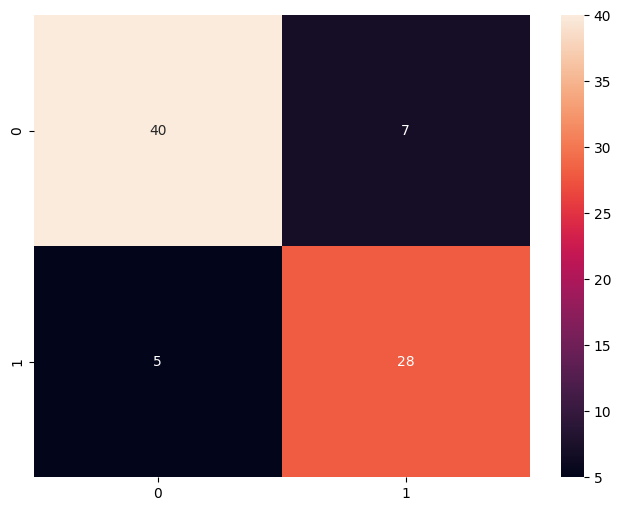

In [52]:
metrics(y_valid, y_pred, scores_valid)

In [53]:
with open('./models_skab/pipeline_LOF_RL_dwt.pkl', 'wb') as file: 
    pickle.dump(best_model_lof, file)

## Algorithms Pyod
https://pyod.readthedocs.io/en/latest/

In [ ]:
import numpy as np
import gym
from gym import spaces
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import time

class AnomalyDetectionEnv_Pyod(gym.Env):
    def __init__(self, X, y, tscv, features, model_factory, param_ranges):
        """
        Ambiente de RL para otimização de modelos de detecção de anomalias.

        :param X: Dados de entrada (numpy array)
        :param y: Rótulos (numpy array)
        :param tscv: TimeSeriesSplit para validação cruzada
        :param features: Lista de features usadas
        :param model_factory: Função que recebe um conjunto de hiperparâmetros e retorna um modelo
        :param param_ranges: Dicionário com limites inferior e superior para cada hiperparâmetro
        """
        super(AnomalyDetectionEnv_Pyod, self).__init__()

        self.X = X
        self.y = y
        self.tscv = tscv
        self.features = features
        self.model_factory = model_factory
        self.param_ranges = param_ranges

        # Espaço de ação baseado nos hiperparâmetros
        low_bounds = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)
        high_bounds = np.array([param_ranges[p][1] for p in param_ranges], dtype=np.float32)
        self.action_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Espaço de observação (hiperparâmetros atuais)
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Estado inicial: média dos limites dos hiperparâmetros
        # self.state = np.array([(param_ranges[p][0] + param_ranges[p][1]) / 2 for p in param_ranges], dtype=np.float32)
        self.state = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)

        # # Histórico de métricas
        # self.metrics_history = {
        #     'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': []
        # }

        self.metrics_history = {
            'roc_auc': []
        }

        self.rewards_history = []  # Histórico de recompensas
        self.q_values_history = []  # Histórico de Q-values
        # self.entropy_history = []  # Histórico de entropia
        # self.critic_loss_history = []  # Histórico de critic loss

        # Lista para armazenar os resultados detalhados de cada rodada
        self.results = []

    # def find_optimal_threshold(self, y_true, y_scores, metric='f1'):
    #     precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    #     try:
    #         f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    #     except:
    #           f1_scores = 0    
    #     best_idx = np.argmax(f1_scores)
    #     return thresholds[best_idx], f1_scores[best_idx]

    def step(self, action):
        # Verificar se a ação contém valores inválidos
        if np.isnan(action).any():
            print("Ação inválida detectada:", action)
            return self.reset(), 0, True, {"invalid_action": True}

        # Criar dicionário de hiperparâmetros ajustados dentro dos limites
        params = {key: np.clip(action[i], *self.param_ranges[key]) for i, key in enumerate(self.param_ranges)}

        # Criar o modelo com os hiperparâmetros escolhidos
        model = self.model_factory(**params)

        # Pipeline de pré-processamento e modelo
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Validação cruzada e avaliação do modelo
        # split_scores = {
        #     'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': [], 'fit_time': [], 'score_time': []
        # }
        split_scores = {
            'roc_auc': [], 'fit_time': [], 'score_time': []
        }

        for train_index, test_index in self.tscv.split(self.X):
            # Filtrar apenas eventos normais no conjunto de treinamento
            X_train_split = self.X[train_index][self.y[train_index] == 0]

            X_test_split = self.X[test_index]
            y_test_split = self.y[test_index]

            start_fit = time.time()
            pipeline.fit(X_train_split)
            fit_time = time.time() - start_fit

            start_score = time.time()
            y_scores = pipeline.decision_function(X_test_split) if hasattr(pipeline, "decision_function") else pipeline.predict_proba(X_test_split)[:, 1]
            # y_pred = pipeline.predict(X_test_split)
            score_time = time.time() - start_score

            # Mapear previsões para anomalias (0 = normal, 1 = anomalia)
            # y_pred = np.where(y_pred == -1, 1, 0)
            # best_threshold, best_f1 = self.find_optimal_threshold(y_test_split, y_scores)
            # y_pred = (y_scores >= best_threshold).astype(int)

            # Calcular métricas
            # precision = precision_score(y_test_split, y_pred, average='binary', zero_division=0)
            # recall = recall_score(y_test_split, y_pred, average='binary', zero_division=0)
            # f1 = f1_score(y_test_split, y_pred, average='binary', zero_division=0)
            roc_auc = roc_auc_score(y_test_split, y_scores)#, max_fpr=0.1)
            # try:
            #     roc_auc = roc_auc_score(y_test_split, y_pred)
            # except:
                # roc_auc=0    
            # pr_auc = average_precision_score(y_test_split, y_scores)      

            # # Calcular especificidade
            # tn, fp, fn, tp = confusion_matrix(y_test_split, y_pred).ravel()
            # specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            # split_scores['f1_score'].append(f1)
            # split_scores['precision'].append(precision)
            # split_scores['recall'].append(recall)
            split_scores['roc_auc'].append(roc_auc)
            # split_scores['pr_auc'].append(pr_auc)
            # split_scores['specificity'].append(specificity)
            split_scores['fit_time'].append(fit_time)
            split_scores['score_time'].append(score_time)

        # Adicionar resultados detalhados
        self.results.append({
            "params": params,
            "fold_scores": split_scores,
            # "mean_test_f1_score": np.mean(split_scores['f1_score']),
            # "std_test_f1_score": np.std(split_scores['f1_score']),
            # "mean_test_specificity": np.mean(split_scores['specificity']),
            # "std_test_specificity": np.std(split_scores['specificity']),
            # "mean_test_precision": np.mean(split_scores['precision']),
            # "std_test_precision": np.std(split_scores['precision']),
            # "mean_test_recall": np.mean(split_scores['recall']),
            # "std_test_recall": np.std(split_scores['recall']),
            "mean_test_roc_auc": np.mean(split_scores['roc_auc']),
            "std_test_roc_auc": np.std(split_scores['roc_auc']),
            # "mean_test_pr_auc": np.mean(split_scores['pr_auc']),
            # "std_test_pr_auc": np.std(split_scores['pr_auc']),
            "mean_fit_time": np.mean(split_scores['fit_time']),
            "std_fit_time": np.std(split_scores['fit_time']),
            "mean_score_time": np.mean(split_scores['score_time']),
            "std_score_time": np.std(split_scores['score_time']),
        })

        # Recompensa baseada no AUC-ROC médio
        # reward = 1*(np.mean(split_scores['roc_auc']))

        # reward = 2 * np.mean(split_scores['roc_auc']) - 1
        reward = 100*(np.mean(split_scores['roc_auc']) - np.std(split_scores['roc_auc']))
        # reward = 100*(np.mean(split_scores['f1_score']) - np.std(split_scores['f1_score']))

        # reward = np.mean(split_scores['f1_score'])
        # reward = np.mean(split_scores['pr_auc'])

        self.rewards_history.append(reward)

        # Atualizar histórico de métricas
        for metric in self.metrics_history:
            self.metrics_history[metric].append(np.mean(split_scores[metric]))

        # Atualizar estado
        self.state = np.array(list(params.values()), dtype=np.float32)

        return self.state, reward, True, {}

    def reset(self):
        self.state = np.array([(self.param_ranges[p][0] + self.param_ranges[p][1]) / 2 for p in self.param_ranges], dtype=np.float32)
        return self.state

    def render(self, mode='human'):
        pass

    def get_results_table(self):
        """ Retorna um DataFrame com os resultados da validação cruzada. """
        return pd.DataFrame(self.results)

#### PCA

In [82]:
def pca_factory(**params):
    return PCA(
        contamination=params['contamination'],
        n_components=params['n_components']
    )

n_comp = train.shape[1]-1

param_ranges_pca = {
    'contamination': (0.0001, 0.005),
    'n_components': (0.5, 1)
}

In [83]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv_Pyod(X_dev, y_dev, tscv, feature_model, pca_factory, param_ranges_pca)

# Modelo SAC
model_pca_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)
start_time = time.time()  # Inicia o cronômetro
# Treinamento do agente
callback = SACMetricsCallback()
model_pca_sac.learn(total_timesteps=1000, callback=callback)

total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 90.6     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 50       |
|    time_elapsed    | 0        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 91.1     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 48       |
|    time_elapsed    | 0        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 91.1     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [84]:
results_df_pca = env.get_results_table()
results_df_pca.head()

,params,fold_scores,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'contamination': 0.0030826579313725233, 'n_co...","{'roc_auc': [0.8882978723404256, 0.95678191489...",0.932231,0.031137,0.004865,0.000669,0.000664,0.000469
1,"{'contamination': 0.0007362242904491723, 'n_co...","{'roc_auc': [0.9042553191489361, 0.93683510638...",0.930901,0.019784,0.002327,0.000471,0.000000,0.000000
2,"{'contamination': 0.004726703278720379, 'n_com...","{'roc_auc': [0.9042553191489361, 0.93683510638...",0.930901,0.019784,0.002991,0.000815,0.000333,0.000470
3,"{'contamination': 0.0005880692624486983, 'n_co...","{'roc_auc': [0.8882978723404256, 0.95678191489...",0.932231,0.031137,0.002327,0.000471,0.000665,0.000470
4,"{'contamination': 0.000689819164108485, 'n_com...","{'roc_auc': [0.910904255319149, 0.947473404255...",0.935767,0.017591,0.003656,0.000469,0.000000,0.000000


In [85]:
results_df_pca.to_csv('./metrics_skab/results_df_pca_dwt.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

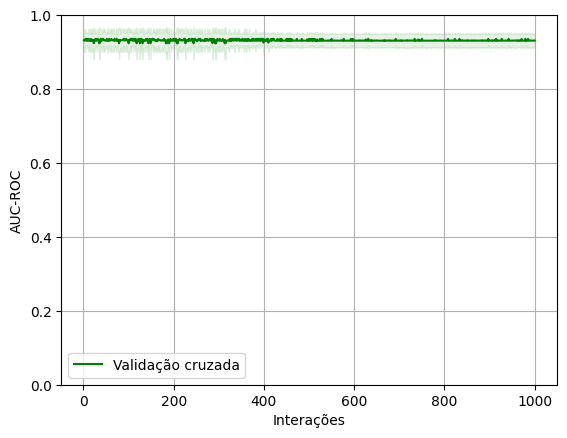

In [86]:
results_df_pca2 = pd.read_csv('./metrics_skab/results_df_pca_dwt.csv')

results_df_pca2  = results_df_pca2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_pca2, title="pca", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [87]:
results_df_pca['roc_auc_adjusted'] = results_df_pca['mean_test_roc_auc'] - results_df_pca['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_pca['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_pca.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 


Melhores parâmetros encontrados (máxima média ajustada): {'contamination': 0.000689819164108485, 'n_components': 0.9141202569007874}

Métricas: params               {'contamination': 0.000689819164108485, 'n_com...
fold_scores          {'roc_auc': [0.910904255319149, 0.947473404255...
mean_test_roc_auc                                             0.935767
std_test_roc_auc                                              0.017591
mean_fit_time                                                 0.003656
std_fit_time                                                  0.000469
mean_score_time                                                    0.0
std_score_time                                                     0.0
roc_auc_adjusted                                              0.918177
Name: 4, dtype: object


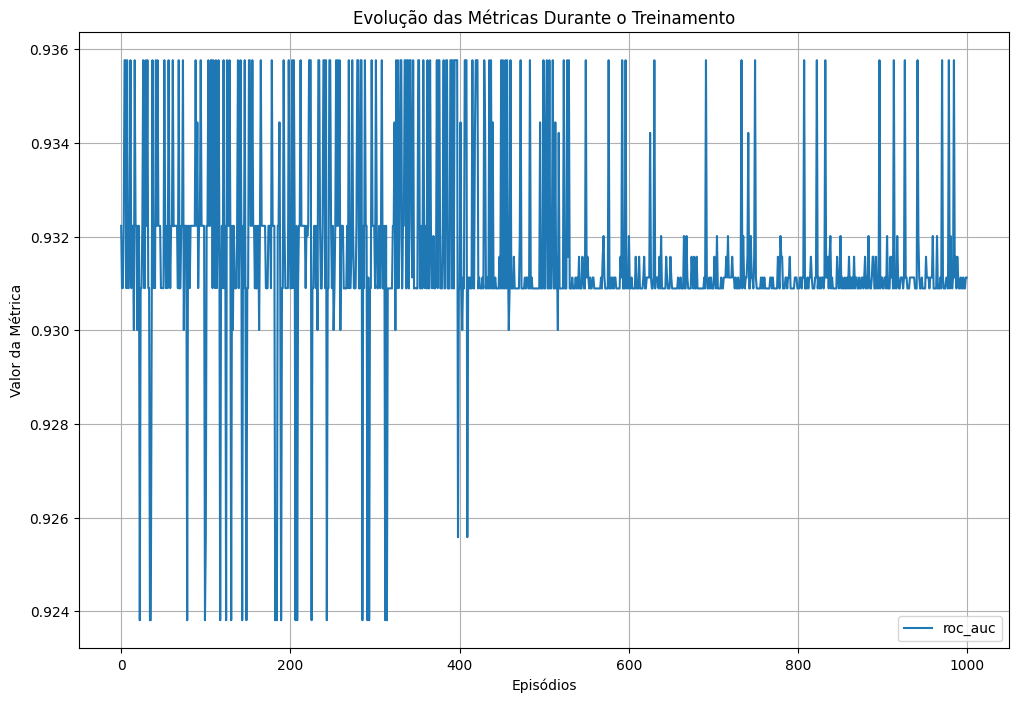

In [88]:
plot_metrics(env.metrics_history)

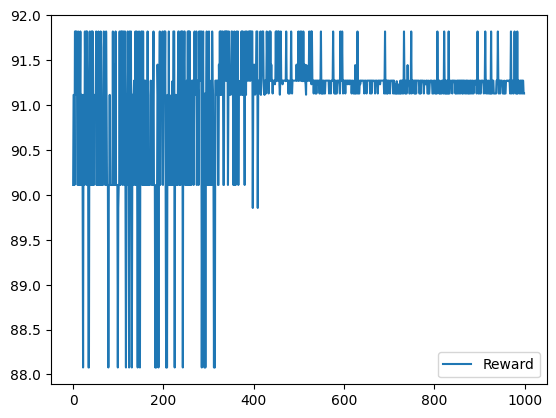

In [89]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

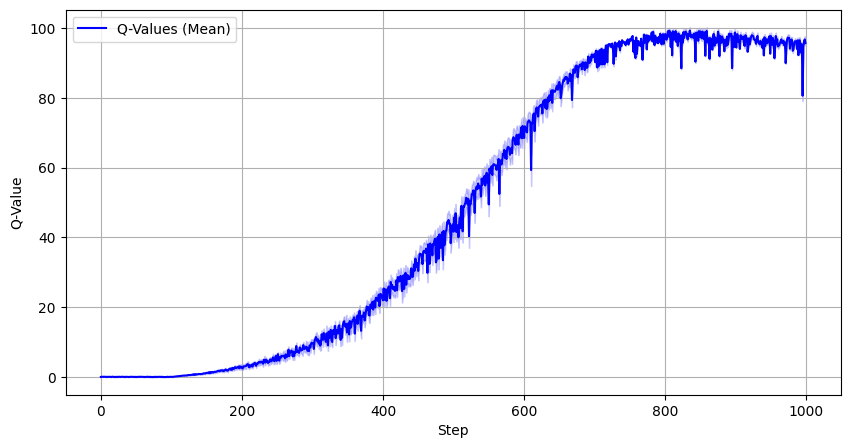

In [90]:
# plt.plot(callback.q_values_history, label="Q-Values")
# plt.legend()
# plt.show()


q_mean = np.array(callback.q_values_mean_history)
q_std = np.array(callback.q_values_std_history)

plt.figure(figsize=(10, 5))
plt.plot(q_mean, label="Q-Values (Mean)", color="blue")
plt.fill_between(range(len(q_mean)),
                 q_mean - q_std,
                 q_mean + q_std,
                 alpha=0.2, color="blue")
plt.xlabel("Step")
plt.ylabel("Q-Value")
# plt.title("Evolução dos Q-Values (Média ± Desvio Padrão)")
plt.legend()
plt.grid(True)
plt.show()

In [91]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_skab/rewards_history_pca_dwt.csv', index=False)
pd.DataFrame(callback.q_values_mean_history).to_csv('./metrics_skab/q_values_mean_history_pca_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q1_history).to_csv('./metrics_skab/q_values_q1_history_pca_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q2_history).to_csv('./metrics_skab/q_values_q2_history_pca_dwt.csv', index=False)
pd.DataFrame(callback.q_values_std_history).to_csv('./metrics_skab/q_values_std_history_pca_dwt.csv', index=False)
# pd.DataFrame(callback.entropy_history).to_csv('./metrics_skab/entropy_history_pca_dwt.csv', index=False)

In [92]:
best_params['params']

{'contamination': 0.000689819164108485, 'n_components': 0.9141202569007874}

In [93]:

contamination_best = round(float(best_params['params'].get('contamination')), 5)
n_components_best = round(float(best_params['params'].get('n_components')), 2)


print(f"Melhores hiperparâmetros encontrados: contamination={contamination_best}, "
      f"n_components={n_components_best}")

Melhores hiperparâmetros encontrados: contamination=0.00069, n_components=0.91


In [94]:
if n_components_best==1.0:
    n_components_best=0.99
else:
    pass

In [95]:
estimator = PCA(random_state=42, 
                contamination = contamination_best,
                n_components = n_components_best
                
                )

best_model_pca = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

best_model_pca.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 PCA(contamination=0.00069, copy=True, iterated_power='auto',
  n_components=0.91, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False))])

In [96]:
scale_pca = best_model_pca[0]

In [97]:
media = scale_pca.mean_

desvio_padrao = scale_pca.scale_

print("Média calculada pelo StandardScaler:", media)
print("Desvio padrão calculado pelo StandardScaler:", desvio_padrao)

Média calculada pelo StandardScaler: [32.13214317  0.41968128 31.37052435 32.95132124  0.99988925  0.3487142 ]
Desvio padrão calculado pelo StandardScaler: [1.92908385e-01 6.21776093e-02 4.80677081e-01 1.84802159e-01
 4.22490331e-05 6.37650469e-02]


In [98]:
# y_pred = best_model_pca.predict(development[feature_model])

scores_dev = best_model_pca.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1.0)
print(f"Melhor Threshold: {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold: 85.1365, AUC: 0.9164
Melhore threshold:  85.13650059932735


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.90148   0.94819   0.92424       193
         1.0    0.91379   0.84127   0.87603       126

    accuracy                        0.90596       319
   macro avg    0.90764   0.89473   0.90014       319
weighted avg    0.90634   0.90596   0.90520       319

Specificity: 0.9481865284974094
Gini:  0.8327165062916357
ROC AUC::  0.9163582531458179


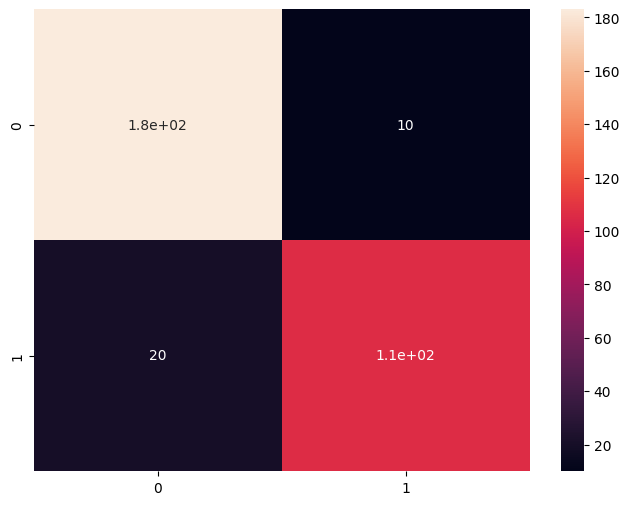

In [99]:
metrics(y_dev, y_pred, scores_dev)

In [100]:
# y_pred = best_model_pca.predict(validation[feature_model])
# y_test = validation.target.values



scores_valid = best_model_pca.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_pred = best_model_pca.predict(X_valid)

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.89362   0.89362   0.89362        47
         1.0    0.84848   0.84848   0.84848        33

    accuracy                        0.87500        80
   macro avg    0.87105   0.87105   0.87105        80
weighted avg    0.87500   0.87500   0.87500        80

Specificity: 0.8936170212765957
Gini:  0.8065764023210833
ROC AUC::  0.9032882011605416


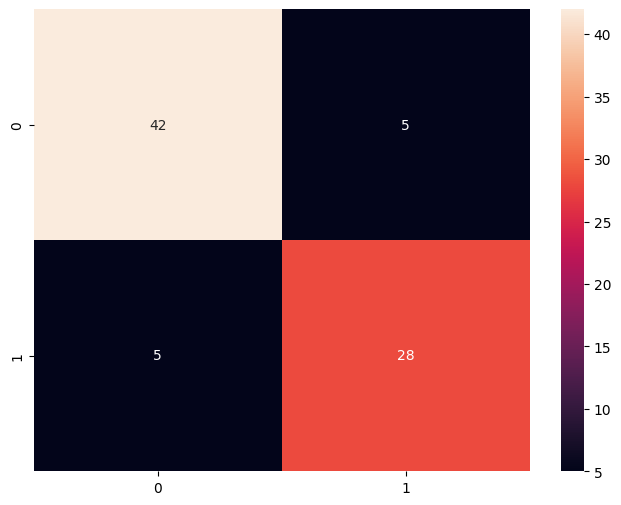

In [101]:
metrics(y_valid, y_pred, scores_valid)

In [102]:
with open('./models_skab/pipeline_PCA_RL_dwt.pkl', 'wb') as file: 
    pickle.dump(best_model_pca, file)

#### LODA

In [103]:
def loda_factory(**params):
    return LODA(
        contamination=params['contamination'],
        n_bins=int(params['n_bins']),
        n_random_cuts=int(params['n_random_cuts'])
    )

param_ranges_loda = {
    'contamination': (0.0001, 0.005),
    'n_bins': (50, 5000),
    'n_random_cuts': (10, 1000)
}

In [104]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv_Pyod(X_dev, y_dev, tscv, feature_model, loda_factory, param_ranges_loda)

# Modelo SAC
model_loda_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

start_time = time.time()  # Inicia o cronômetro

# Treinamento do agente
callback = SACMetricsCallback()
model_loda_sac.learn(total_timesteps=1000, callback=callback)


total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 9.32     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 3        |
|    time_elapsed    | 1        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 9.5      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 10.3     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [105]:
results_df_loda = env.get_results_table()
results_df_loda.head()

,params,fold_scores,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'contamination': 0.002345894230529666, 'n_bin...","{'roc_auc': [0.2300531914893617, 0.03025265957...",0.170998,0.099950,0.101088,0.006301,0.009642,0.001723
1,"{'contamination': 0.0045372177846729755, 'n_bi...","{'roc_auc': [0.26263297872340424, 0.0957446808...",0.214217,0.084237,0.109058,0.004965,0.012816,0.001827
2,"{'contamination': 0.0028096239548176527, 'n_bi...","{'roc_auc': [0.2230718085106383, 0.04720744680...",0.176451,0.092563,0.080817,0.008049,0.007312,0.000467
3,"{'contamination': 0.004657956771552563, 'n_bin...","{'roc_auc': [0.21675531914893614, 0.0531914893...",0.180036,0.092305,0.072371,0.007468,0.006315,0.001882
4,"{'contamination': 0.0005304754013195634, 'n_bi...","{'roc_auc': [0.23404255319148934, 0.0452127659...",0.180675,0.096501,0.147936,0.018226,0.015144,0.002885


In [106]:
results_df_loda.to_csv('./metrics_skab/results_df_loda_dwt.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

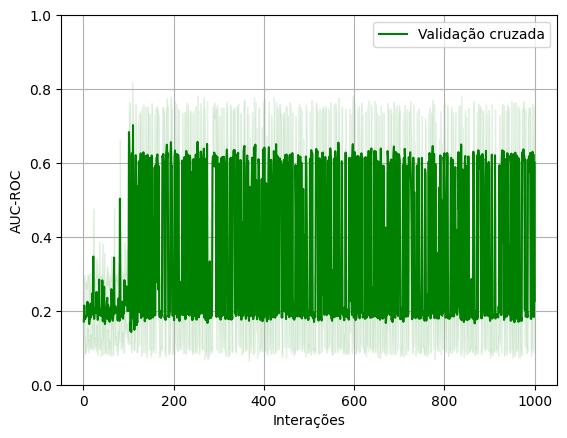

In [107]:
results_df_loda2 = pd.read_csv('./metrics_skab/results_df_loda_dwt.csv')

results_df_loda2  = results_df_loda2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_loda2, title="loda", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [108]:

results_df_loda['roc_auc_adjusted'] = results_df_loda['mean_test_roc_auc'] - results_df_loda['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_loda['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_loda.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 


Melhores parâmetros encontrados (máxima média ajustada): {'contamination': 0.004999999888241291, 'n_bins': 52.06825256347656, 'n_random_cuts': 10.0}

Métricas: params               {'contamination': 0.004999999888241291, 'n_bin...
fold_scores          {'roc_auc': [0.6236702127659576, 0.73603723404...
mean_test_roc_auc                                              0.70234
std_test_roc_auc                                              0.055818
mean_fit_time                                                 0.005866
std_fit_time                                                  0.000831
mean_score_time                                               0.000665
std_score_time                                                 0.00047
roc_auc_adjusted                                              0.646522
Name: 109, dtype: object


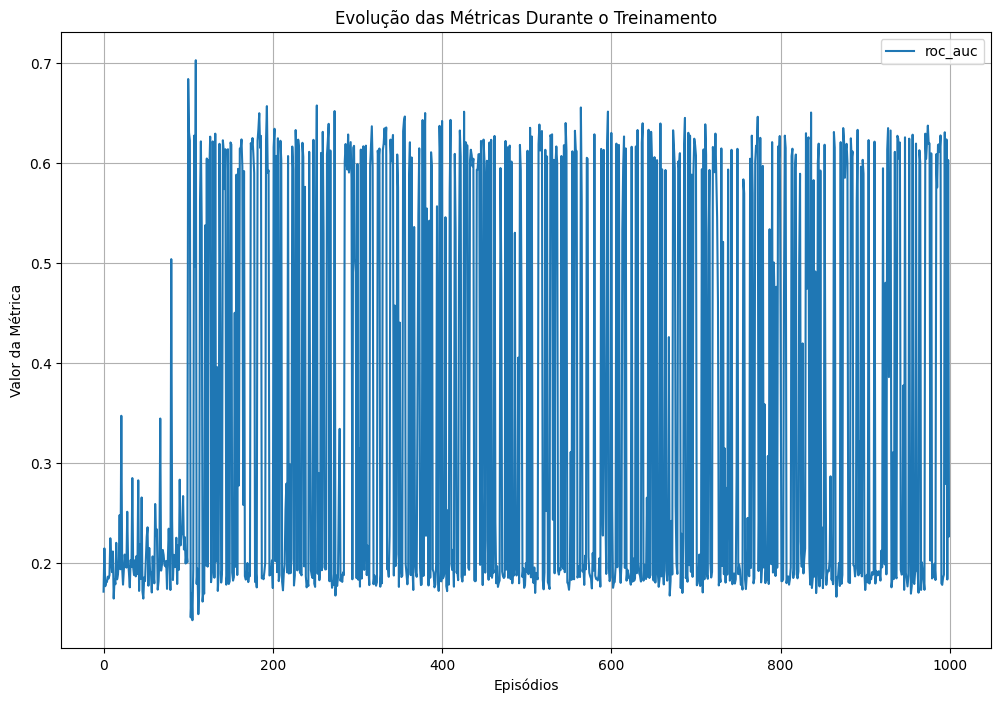

In [109]:
plot_metrics(env.metrics_history)

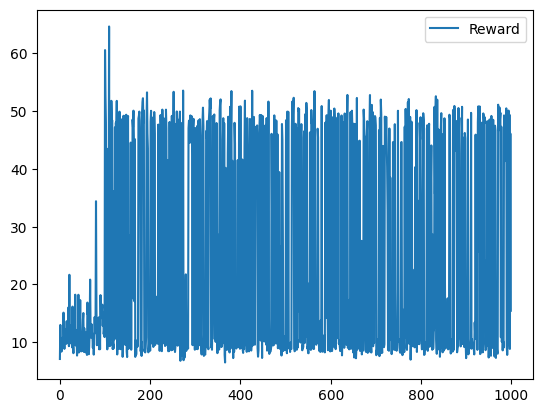

In [110]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()


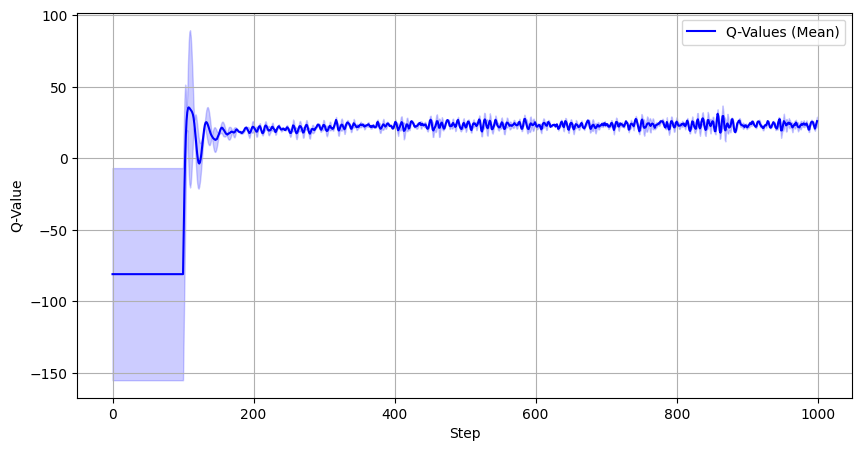

In [111]:
# plt.plot(callback.q_values_history, label="Q-Values")
# plt.legend()
# plt.show()


q_mean = np.array(callback.q_values_mean_history)
q_std = np.array(callback.q_values_std_history)

plt.figure(figsize=(10, 5))
plt.plot(q_mean, label="Q-Values (Mean)", color="blue")
plt.fill_between(range(len(q_mean)),
                 q_mean - q_std,
                 q_mean + q_std,
                 alpha=0.2, color="blue")
plt.xlabel("Step")
plt.ylabel("Q-Value")
# plt.title("Evolução dos Q-Values (Média ± Desvio Padrão)")
plt.legend()
plt.grid(True)
plt.show()

In [112]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_skab/rewards_history_loda_dwt.csv', index=False)
pd.DataFrame(callback.q_values_mean_history).to_csv('./metrics_skab/q_values_mean_history_loda_dwt.csv', index=False)
pd.DataFrame(callback.q_values_std_history).to_csv('./metrics_skab/q_values_std_history_loda_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q1_history).to_csv('./metrics_skab/q_values_q1_history_loda_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q2_history).to_csv('./metrics_skab/q_values_q2_history_loda_dwt.csv', index=False)

In [113]:
best_params['params']

{'contamination': 0.004999999888241291,
 'n_bins': 52.06825256347656,
 'n_random_cuts': 10.0}

In [114]:
n_random_cuts_best = int(best_params['params'].get('n_random_cuts'))
contamination_best = round(float(best_params['params'].get('contamination')), 5)
n_bins_best = int(best_params['params'].get('n_bins'))


print(f"Melhores hiperparâmetros encontrados: n_random_cuts={n_random_cuts_best}, contamination={contamination_best}, "
      f"n_bins={n_bins_best}")

Melhores hiperparâmetros encontrados: n_random_cuts=10, contamination=0.005, n_bins=52


In [115]:
estimator = LODA(contamination=contamination_best, n_bins=n_bins_best, n_random_cuts=n_random_cuts_best)

best_model_loda = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

best_model_loda.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LODA(contamination=0.005, n_bins=52, n_random_cuts=10))])

In [116]:
# y_pred = best_model_loda.predict(validation[feature_model])
# y_test = validation.target.values

scores_dev = best_model_loda.decision_function(X_dev)

fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1.0)
print(f"Melhor Threshold: {best_threshold:.4f}, AUC: {roc_auc:.4f}")

y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhore threshold: ", best_threshold)

Melhor Threshold: 0.3805, AUC: 0.8202
Melhore threshold:  0.38045737459737683


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.90625   0.75130   0.82153       193
         1.0    0.69811   0.88095   0.77895       126

    accuracy                        0.80251       319
   macro avg    0.80218   0.81612   0.80024       319
weighted avg    0.82404   0.80251   0.80471       319

Specificity: 0.7512953367875648
Gini:  0.6403487128875729
ROC AUC::  0.8201743564437864


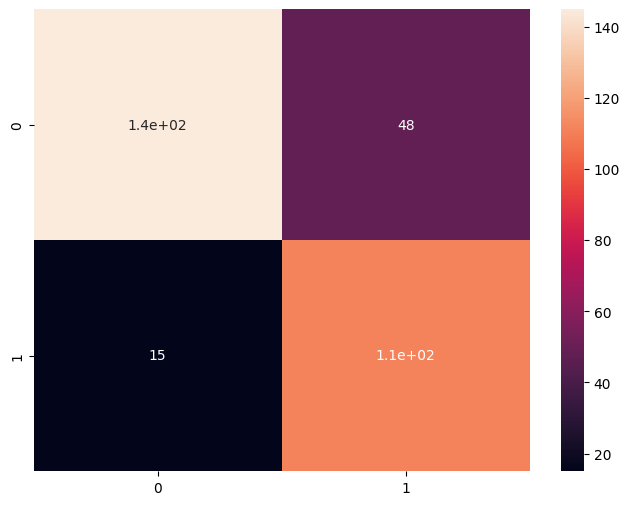

In [117]:
metrics(y_dev, y_pred, scores_dev)

In [118]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [119]:
scores_valid = best_model_loda.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)

# y_pred = best_model_loda.predict(X_valid)

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.90698   0.82979   0.86667        47
         1.0    0.78378   0.87879   0.82857        33

    accuracy                        0.85000        80
   macro avg    0.84538   0.85429   0.84762        80
weighted avg    0.85616   0.85000   0.85095        80

Specificity: 0.8297872340425532
Gini:  0.617666021921341
ROC AUC::  0.8088330109606705


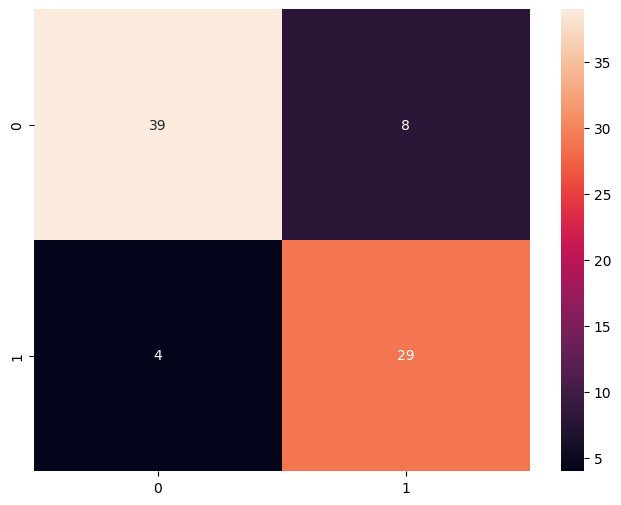

In [120]:
metrics(y_valid, y_pred, scores_valid)

In [121]:
with open('./models_skab/pipeline_LODA_RL_dwt.pkl', 'wb') as file: 
    pickle.dump(best_model_loda, file)

### OCSVM

In [122]:
import numpy as np
import gym
from gym import spaces
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import time

class AnomalyDetectionEnv_Pyod_Cat_Num(gym.Env):
    def __init__(self, X, y, tscv, features, model_factory, param_ranges):
        """
        Ambiente de RL para otimização de modelos de detecção de anomalias.

        :param X: Dados de entrada (numpy array)
        :param y: Rótulos (numpy array)
        :param tscv: TimeSeriesSplit para validação cruzada
        :param features: Lista de features usadas
        :param model_factory: Função que recebe um conjunto de hiperparâmetros e retorna um modelo
        :param param_ranges: Dicionário com limites inferior/superior ou lista de categorias
        """
        super(AnomalyDetectionEnv_Pyod_Cat_Num, self).__init__()

        self.X = X
        self.y = y
        self.tscv = tscv
        self.features = features
        self.model_factory = model_factory
        self.param_ranges = param_ranges

        # Identificar parâmetros categóricos e contínuos
        self.param_names = list(param_ranges.keys())
        self.categorical_params = {k: v for k, v in param_ranges.items() if isinstance(v, list)}
        self.continuous_params = {k: v for k, v in param_ranges.items() if not isinstance(v, list)}

        # Espaço de ação: para categorias usamos índices normalizados
        low_bounds = []
        high_bounds = []
        for k in self.param_names:
            if k in self.categorical_params:
                low_bounds.append(0)
                high_bounds.append(len(self.categorical_params[k]) - 1)
            else:
                low_bounds.append(self.param_ranges[k][0])
                high_bounds.append(self.param_ranges[k][1])

        self.action_space = spaces.Box(low=np.array(low_bounds, dtype=np.float32),
                                       high=np.array(high_bounds, dtype=np.float32),
                                       dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array(low_bounds, dtype=np.float32),
                                            high=np.array(high_bounds, dtype=np.float32),
                                            dtype=np.float32)

        # Estado inicial (meio do intervalo ou primeira categoria)
        self.state = np.array([
            0 if k in self.categorical_params else (self.param_ranges[k][0] + self.param_ranges[k][1]) / 2
            for k in self.param_names
        ], dtype=np.float32)

        self.metrics_history = {'roc_auc': []}
        self.rewards_history = []
        self.results = []

    def step(self, action):
        if np.isnan(action).any():
            print("Ação inválida detectada:", action)
            return self.reset(), 0, True, {"invalid_action": True}

        params = {}
        for i, k in enumerate(self.param_names):
            if k in self.categorical_params:
                # Converter para inteiro e mapear para categoria
                idx = int(np.clip(round(action[i]), 0, len(self.categorical_params[k]) - 1))
                params[k] = self.categorical_params[k][idx]
            else:
                params[k] = float(np.clip(action[i], *self.param_ranges[k]))

        model = self.model_factory(**params)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        split_scores = {'roc_auc': [], 'fit_time': [], 'score_time': []}

        for train_index, test_index in self.tscv.split(self.X):
            X_train_split = self.X[train_index][self.y[train_index] == 0]
            X_test_split = self.X[test_index]
            y_test_split = self.y[test_index]

            start_fit = time.time()
            pipeline.fit(X_train_split)
            fit_time = time.time() - start_fit

            start_score = time.time()
            y_scores = pipeline.decision_function(X_test_split) if hasattr(pipeline, "decision_function") else pipeline.predict_proba(X_test_split)[:, 1]
            # y_pred = pipeline.predict(X_test_split)
            score_time = time.time() - start_score

            roc_auc = roc_auc_score(y_test_split, y_scores)
            # f1 = f1_score(y_test_split, y_pred, average='binary', zero_division=0)

            split_scores['roc_auc'].append(roc_auc)
            # split_scores['f1_score'].append(f1)
            split_scores['fit_time'].append(fit_time)
            split_scores['score_time'].append(score_time)

        self.results.append({
            "params": params,
            "fold_scores": split_scores,
            "mean_test_roc_auc": np.mean(split_scores['roc_auc']),
            "std_test_roc_auc": np.std(split_scores['roc_auc']),
            # "mean_test_f1_score": np.mean(split_scores['f1_score']),
            # "std_test_f1_score": np.std(split_scores['f1_score']),
            "mean_fit_time": np.mean(split_scores['fit_time']),
            "std_fit_time": np.std(split_scores['fit_time']),
            "mean_score_time": np.mean(split_scores['score_time']),
            "std_score_time": np.std(split_scores['score_time']),
        })

        reward = 100 * (np.mean(split_scores['roc_auc']) - np.std(split_scores['roc_auc']))
        # reward = 100 * (np.mean(split_scores['f1_score']) - np.std(split_scores['f1_score']))
        self.rewards_history.append(reward)
        self.metrics_history['roc_auc'].append(np.mean(split_scores['roc_auc']))
        self.state = np.array(list(action), dtype=np.float32)

        return self.state, reward, True, {}

    def reset(self):
        self.state = np.array([
            0 if k in self.categorical_params else (self.param_ranges[k][0] + self.param_ranges[k][1]) / 2
            for k in self.param_names
        ], dtype=np.float32)
        return self.state

    def render(self, mode='human'):
        pass

    def get_results_table(self):
        return pd.DataFrame(self.results)


In [123]:
from pyod.models.ocsvm import OCSVM

def ocsvm_factory(**params):
    return OCSVM(
        kernel=params['kernel'],
        nu=params['nu'],
        gamma=params['gamma']
    )

param_ranges_ocsvm = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],  # kernels suportados
    'nu': (0.0001, 0.005),  # proporção de outliers esperada (0 < nu ≤ 1)
    'gamma': (0.001, 0.1)  # parâmetro do kernel RBF/poly/sigmoid
}

In [124]:
# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv_Pyod_Cat_Num(X_dev, y_dev, tscv, feature_model, ocsvm_factory, param_ranges_ocsvm)

# Modelo SAC
model_ocsvm_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

start_time = time.time()  # Inicia o cronômetro

# Treinamento do agente
callback = SACMetricsCallback()
model_ocsvm_sac.learn(total_timesteps=1000, callback=callback)


total_time = time.time() - start_time  # Calcula o tempo total

print("\n--- Resultados Finais ---")
# Melhores parâmetros encontrados
# print("Melhores parâmetros para IsolationForest:", best_params_pca)
print(f"Tempo total de execução: {total_time:.2f} segundos")
print(f"Tempo total de execução: {total_time/60:.2f} minutos")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 57.3     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 14       |
|    time_elapsed    | 0        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 51.5     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 22       |
|    time_elapsed    | 0        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 45.1     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [125]:
results_df_ocsvm = env.get_results_table()
results_df_ocsvm.head()

,params,fold_scores,mean_test_roc_auc,std_test_roc_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'kernel': 'linear', 'nu': 0.00019950856221839...","{'roc_auc': [0.5398936170212766, 0.32313829787...",0.420518,0.089847,0.004849,8.370480e-04,0.000332,4.695721e-04
1,"{'kernel': 'rbf', 'nu': 0.004358087666332722, ...","{'roc_auc': [0.8377659574468085, 0.94880319148...",0.894134,0.045347,0.003162,2.402939e-04,0.000997,4.052337e-07
2,"{'kernel': 'rbf', 'nu': 0.0007194274221546948,...","{'roc_auc': [0.8231382978723404, 0.92287234042...",0.880391,0.042035,0.002992,6.743496e-07,0.000665,4.700781e-04
3,"{'kernel': 'linear', 'nu': 0.00126757752150297...","{'roc_auc': [0.382313829787234, 0.267952127659...",0.321818,0.046923,0.004655,9.407739e-04,0.003656,4.484422e-03
4,"{'kernel': 'poly', 'nu': 0.002277229679748416,...","{'roc_auc': [0.34175531914893614, 0.0651595744...",0.257054,0.136000,0.003657,4.698531e-04,0.000997,4.899036e-07


In [126]:
results_df_ocsvm.to_csv('./metrics_skab/results_df_ocsvm_dwt.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PhD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

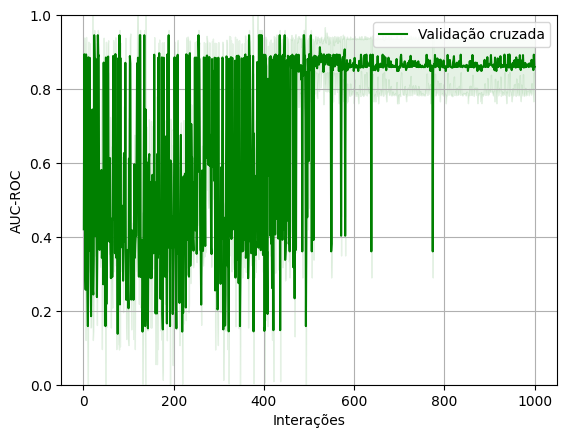

In [127]:
results_df_ocsvm2 = pd.read_csv('./metrics_skab/results_df_ocsvm_dwt.csv')

results_df_ocsvm2  = results_df_ocsvm2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_ocsvm2, title="ocsvm", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [128]:
results_df_ocsvm['roc_auc_adjusted'] = results_df_ocsvm['mean_test_roc_auc'] - results_df_ocsvm['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_ocsvm['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_ocsvm.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 



Melhores parâmetros encontrados (máxima média ajustada): {'kernel': 'poly', 'nu': 0.000887678237631917, 'gamma': 0.010369444265961647}

Métricas: params               {'kernel': 'poly', 'nu': 0.000887678237631917,...
fold_scores          {'roc_auc': [0.9640957446808511, 0.93018617021...
mean_test_roc_auc                                             0.945719
std_test_roc_auc                                              0.013989
mean_fit_time                                                 0.002659
std_fit_time                                                   0.00047
mean_score_time                                               0.000997
std_score_time                                                0.000001
roc_auc_adjusted                                              0.931731
Name: 23, dtype: object


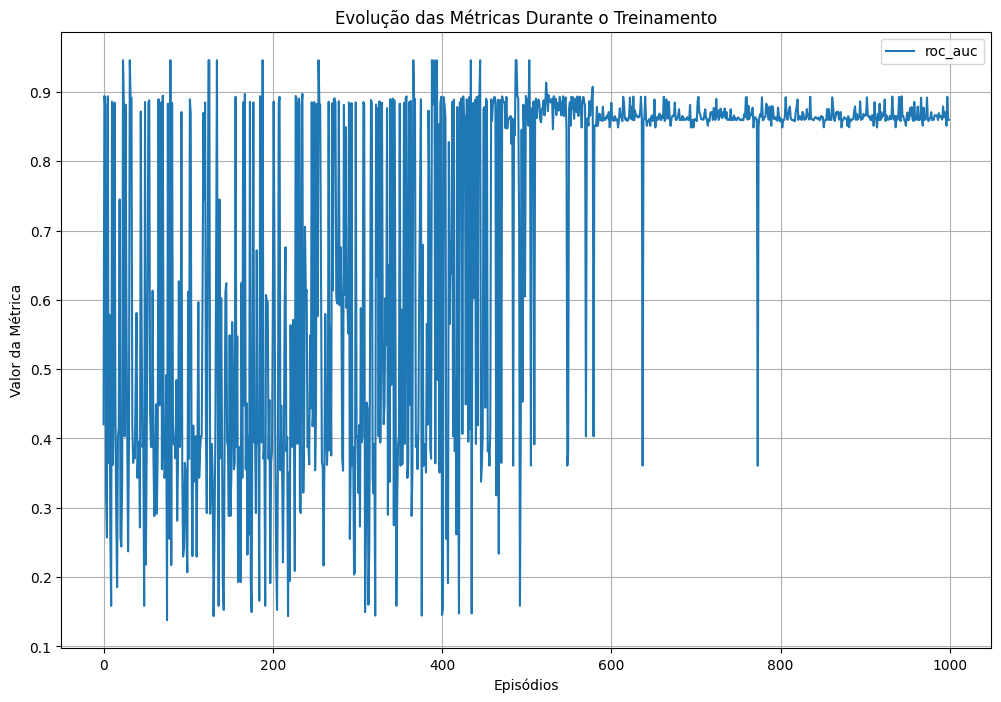

In [129]:
plot_metrics(env.metrics_history)

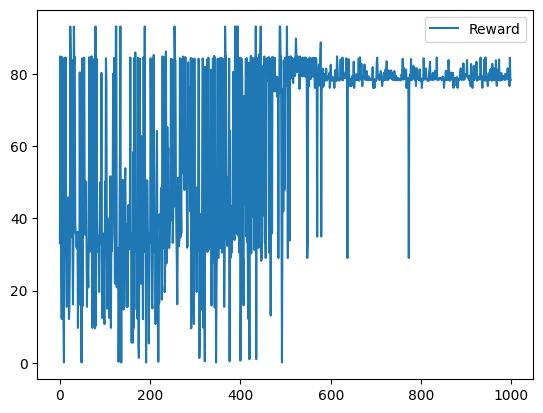

In [130]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

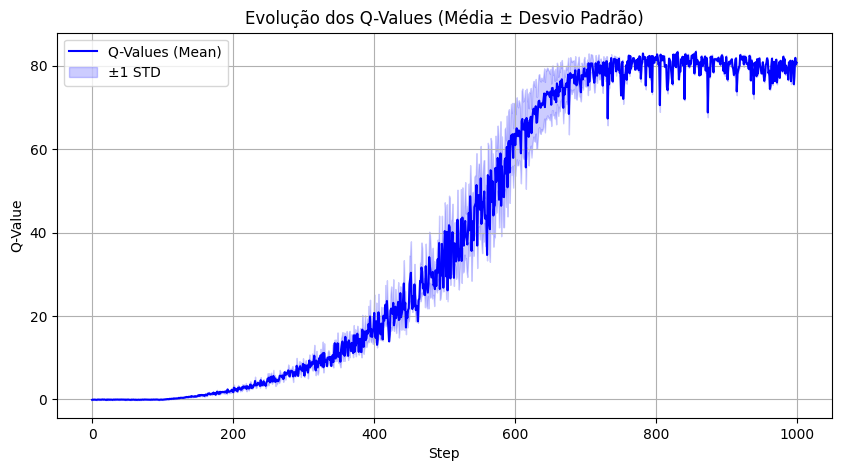

In [131]:
# plt.plot(callback.q_values_history, label="Q-Values")
# plt.legend()
# plt.show()

# Plot dos Q-values: média e desvio padrão
q_mean = np.array(callback.q_values_mean_history)
q_std = np.array(callback.q_values_std_history)

plt.figure(figsize=(10, 5))
plt.plot(q_mean, label="Q-Values (Mean)", color="blue")
plt.fill_between(range(len(q_mean)),
                 q_mean - q_std,
                 q_mean + q_std,
                 alpha=0.2, color="blue", label="±1 STD")
plt.xlabel("Step")
plt.ylabel("Q-Value")
plt.title("Evolução dos Q-Values (Média ± Desvio Padrão)")
plt.legend()
plt.grid(True)
plt.show()


In [132]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_skab/rewards_history_ocsvm_dwt.csv', index=False)
pd.DataFrame(callback.q_values_mean_history).to_csv('./metrics_skab/q_values_mean_history_ocsvm_dwt.csv', index=False)
pd.DataFrame(callback.q_values_std_history).to_csv('./metrics_skab/q_values_std_history_ocsvm_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q1_history).to_csv('./metrics_skab/q_values_q1_history_ocsvm_dwt.csv', index=False)
pd.DataFrame(callback.q_values_q2_history).to_csv('./metrics_skab/q_values_q2_history_ocsvm_dwt.csv', index=False)


In [133]:
# Extrair melhores hiperparâmetros
kernel_best = best_params['params'].get('kernel')
nu_best = round(float(best_params['params'].get('nu')), 5)
gamma_best = round(float(best_params['params'].get('gamma')), 3)

print(f"Melhores hiperparâmetros encontrados: kernel={kernel_best}, nu={nu_best}, gamma={gamma_best}")


Melhores hiperparâmetros encontrados: kernel=poly, nu=0.00089, gamma=0.01


In [134]:
estimator = OCSVM(kernel=kernel_best, nu=nu_best, gamma=gamma_best)

best_model_ocsvm = Pipeline([
    ('scaler', StandardScaler()),
    ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
    ('estimator', estimator)
])

best_model_ocsvm.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma=0.01,
   kernel='poly', max_iter=-1, nu=0.00089, shrinking=True, tol=0.001,
   verbose=False))])

In [135]:
scores_dev = best_model_ocsvm.decision_function(X_dev)

In [136]:
fpr, tpr, thresholds, best_threshold, roc_auc = find_optimal_threshold(y_dev, scores_dev, max_fpr=1.0)
print(f"Melhor Threshold: {best_threshold:.4f}, AUC: {roc_auc:.4f}")


Melhor Threshold: 0.0001, AUC: 0.9036


In [137]:
y_pred = (scores_dev >= best_threshold).astype(int)
print("Melhor threshold: ", best_threshold)

Melhor threshold:  7.483555919057612e-05


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.85922   0.91710   0.88722       193
         1.0    0.85841   0.76984   0.81172       126

    accuracy                        0.85893       319
   macro avg    0.85882   0.84347   0.84947       319
weighted avg    0.85890   0.85893   0.85740       319

Specificity: 0.917098445595855
Gini:  0.8071387449625791
ROC AUC::  0.9035693724812895


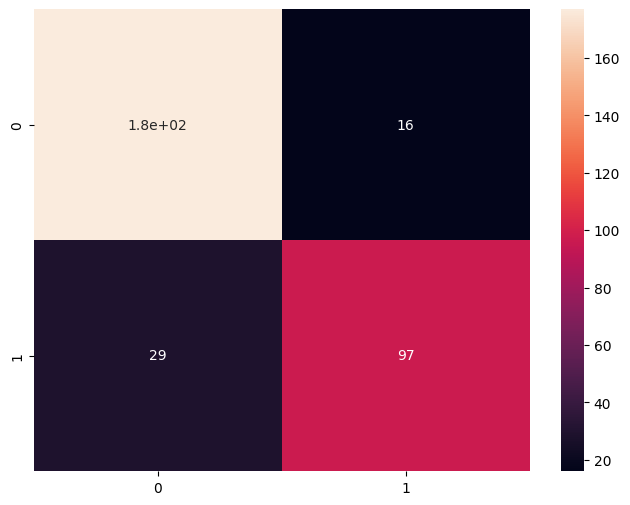

In [138]:
metrics(y_dev, y_pred, scores_dev)

In [139]:
scores_valid = best_model_ocsvm.decision_function(X_valid)
y_pred = (scores_valid >= best_threshold).astype(int)
# y_pred = best_model_ocsvm.predict(X_valid)

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.90909   0.85106   0.87912        47
         1.0    0.80556   0.87879   0.84058        33

    accuracy                        0.86250        80
   macro avg    0.85732   0.86493   0.85985        80
weighted avg    0.86638   0.86250   0.86322        80

Specificity: 0.851063829787234
Gini:  0.8916827852998064
ROC AUC::  0.9458413926499032


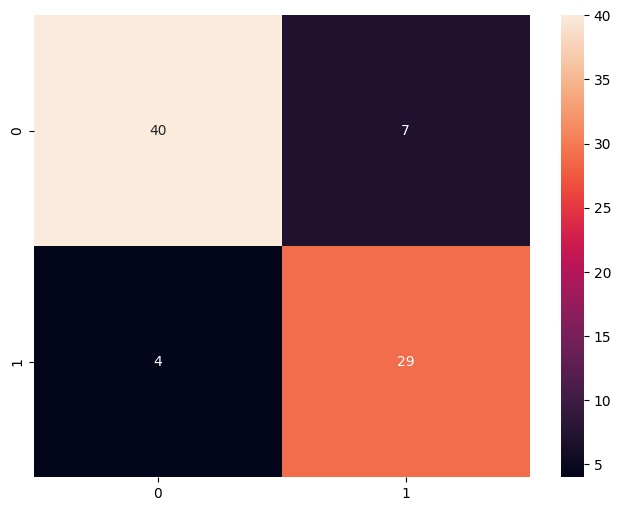

In [140]:
metrics(y_valid, y_pred, scores_valid)

In [141]:
with open('./models_skab/pipeline_OCSVM_RL_dwt.pkl', 'wb') as file: 
    pickle.dump(best_model_ocsvm, file)